# Lightweight Martian Terrain Segmentation with Explainability

This notebook demonstrates:

- Loading the AI4Mars dataset (Hugging Face: `hassanjbara/AI4MARS`).
- Training a lightweight U-Net on Martian terrain labels:
  - Classes: soil, bedrock, sand, big rock (null pixels ignored).
- Evaluating pixel accuracy and mean IoU.
- Visualizing predictions vs. ground truth.
- Explainability:
  - Grad-CAM heatmaps.
  - Integrated Gradients saliency.
  - "Neural PCA" of intermediate feature activations.


In [1]:
import os
import random
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from models import create_unet
from dataloader import (
    create_ai4mars_dataloaders,
    AI4MARS_CLASS_NAMES,
    AI4MARS_IGNORE_INDEX,
)
from optimizers import create_optimizer, create_cosine_scheduler_with_warmup
from train_utils import train_one_epoch, evaluate, save_checkpoint, load_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_size = 256
batch_size = 10
num_workers = 4
num_classes = len(AI4MARS_CLASS_NAMES)
num_epochs = 40

use_muon = False       
use_amp = True 

out_dir = Path("./outputs")
out_dir.mkdir(exist_ok=True, parents=True)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


/home/georg/miniconda3/envs/deep_learning_ex_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Data: AI4Mars dataloaders (train/val/test)
loaders = create_ai4mars_dataloaders(
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    val_fraction=0.1,
    to_rgb=False,
    seed=seed,
    cache_dir="./data/hf_cache",  
    #max_train_samples=100,         
    #max_test_samples=50,
    use_local_disk_copy=True,
    local_disk_path="./data/ai4mars_hf_on_disk",
    scan_spurious=False,
    valid_indices_cache_dir="./data/ai4mars_valid_indices",
)

train_loader = loaders.train
val_loader = loaders.val
test_loader = loaders.test

print(
    f"Train batches: {len(train_loader)}, "
    f"Val batches: {len(val_loader)}, "
    f"Test batches: {len(test_loader)}"
)


[AI4MarsHFDataset] Loaded 13018 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_train.npy
[AI4MarsHFDataset] Loaded 1449 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_val.npy
[AI4MarsHFDataset] Loaded 1597 valid indices from cache: ./data/ai4mars_valid_indices/valid_indices_test.npy
Train batches: 1302, Val batches: 145, Test batches: 160


In [3]:
from models import create_teacher_unet
teacher_learning_rate = 1e-4
teacher_weight_decay = 1e-2
 
# Initializing the teacher model
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)

teacher_optimizer = create_optimizer(
    teacher,
    lr=teacher_learning_rate,
    weight_decay=teacher_weight_decay,
    use_muon=use_muon,
)

teacher_scheduler = create_cosine_scheduler_with_warmup(
    teacher_optimizer,
    num_warmup_steps=int(0.1 * num_epochs * len(train_loader)),
    num_training_steps=num_epochs * len(train_loader),
)


[optimizers] Using NAdam (NadamW-style) optimizer.


In [4]:
history_teacher = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}
# Training loop for the teacher model
best_teacher_miou = -1.0

for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch(
        model=teacher,
        dataloader=train_loader,
        optimizer=teacher_optimizer,
        device=device,
        num_classes=num_classes,
        use_amp=use_amp,
        use_tqdm=True,
        epoch=epoch,
        num_epochs=num_epochs,
        scheduler=teacher_scheduler,
    )

    val_metrics = evaluate(
        model=teacher,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
        use_tqdm=True,
    )

    if val_metrics["miou"] > best_teacher_miou:
        best_teacher_miou = val_metrics["miou"]
        save_checkpoint(
            path="checkpoints/best_teacher.pt",
            model=teacher,
            optimizer=teacher_optimizer,
            scheduler=teacher_scheduler,
            epoch=epoch,
            metrics={"val_miou": best_teacher_miou},
        )
    history_teacher["train_loss"].append(train_metrics["loss"])
    history_teacher["train_miou"].append(train_metrics["miou"])
    history_teacher["val_loss"].append(val_metrics["loss"])
    history_teacher["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )

/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Train Epoch 1/40:   0%|          | 0/1302 [00:00<?, ?batch/s]/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.7825, mIoU: 0.4385, pix acc: 0.7414
  Val   - loss: 0.4769, mIoU: 0.5454, pix acc: 0.8752


  Train - loss: 0.4911, mIoU: 0.5274, pix acc: 0.8424
  Val   - loss: 0.4277, mIoU: 0.5338, pix acc: 0.8559


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.4163, mIoU: 0.5476, pix acc: 0.8587
  Val   - loss: 0.3294, mIoU: 0.5852, pix acc: 0.8935


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.3825, mIoU: 0.5587, pix acc: 0.8666
  Val   - loss: 0.3353, mIoU: 0.5875, pix acc: 0.8881


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.3519, mIoU: 0.5742, pix acc: 0.8785
  Val   - loss: 0.2658, mIoU: 0.6260, pix acc: 0.9141


  Train - loss: 0.3315, mIoU: 0.5889, pix acc: 0.8879
  Val   - loss: 0.2783, mIoU: 0.6238, pix acc: 0.9142


  Train - loss: 0.3063, mIoU: 0.6031, pix acc: 0.8967
  Val   - loss: 0.4725, mIoU: 0.5681, pix acc: 0.8687


  Train - loss: 0.3010, mIoU: 0.6077, pix acc: 0.8996
  Val   - loss: 0.3365, mIoU: 0.5975, pix acc: 0.8917


  Train - loss: 0.2860, mIoU: 0.6241, pix acc: 0.9055
  Val   - loss: 0.2906, mIoU: 0.6221, pix acc: 0.9081


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.2814, mIoU: 0.6209, pix acc: 0.9074
  Val   - loss: 0.2275, mIoU: 0.6512, pix acc: 0.9265


  Train - loss: 0.2556, mIoU: 0.6338, pix acc: 0.9163
  Val   - loss: 0.2713, mIoU: 0.6290, pix acc: 0.9094


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.2402, mIoU: 0.6439, pix acc: 0.9217
  Val   - loss: 0.1977, mIoU: 0.6648, pix acc: 0.9341


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.2279, mIoU: 0.6542, pix acc: 0.9261
  Val   - loss: 0.1902, mIoU: 0.6700, pix acc: 0.9389


  Train - loss: 0.2197, mIoU: 0.6586, pix acc: 0.9295
  Val   - loss: 0.1818, mIoU: 0.6693, pix acc: 0.9380


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.2031, mIoU: 0.6673, pix acc: 0.9351
  Val   - loss: 0.1896, mIoU: 0.6816, pix acc: 0.9411


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.2008, mIoU: 0.6696, pix acc: 0.9359
  Val   - loss: 0.1637, mIoU: 0.7047, pix acc: 0.9506


  Train - loss: 0.1883, mIoU: 0.6823, pix acc: 0.9408
  Val   - loss: 0.1652, mIoU: 0.6968, pix acc: 0.9488


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1890, mIoU: 0.6755, pix acc: 0.9397
  Val   - loss: 0.1600, mIoU: 0.7069, pix acc: 0.9495


  Train - loss: 0.1767, mIoU: 0.6870, pix acc: 0.9452
  Val   - loss: 0.1878, mIoU: 0.6814, pix acc: 0.9373


  Train - loss: 0.1740, mIoU: 0.6848, pix acc: 0.9455
  Val   - loss: 0.1681, mIoU: 0.7043, pix acc: 0.9433


  Train - loss: 0.1700, mIoU: 0.6874, pix acc: 0.9470
  Val   - loss: 0.1621, mIoU: 0.7025, pix acc: 0.9460


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1641, mIoU: 0.6939, pix acc: 0.9496
  Val   - loss: 0.1625, mIoU: 0.7101, pix acc: 0.9506


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1569, mIoU: 0.7015, pix acc: 0.9515
  Val   - loss: 0.1386, mIoU: 0.7223, pix acc: 0.9545


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1525, mIoU: 0.7029, pix acc: 0.9534
  Val   - loss: 0.1409, mIoU: 0.7283, pix acc: 0.9557


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1504, mIoU: 0.7079, pix acc: 0.9537
  Val   - loss: 0.1395, mIoU: 0.7335, pix acc: 0.9551


  Train - loss: 0.1434, mIoU: 0.7131, pix acc: 0.9562
  Val   - loss: 0.1388, mIoU: 0.7300, pix acc: 0.9559


  Train - loss: 0.1397, mIoU: 0.7167, pix acc: 0.9575
  Val   - loss: 0.1373, mIoU: 0.7307, pix acc: 0.9572


  Train - loss: 0.1374, mIoU: 0.7175, pix acc: 0.9585
  Val   - loss: 0.1772, mIoU: 0.7111, pix acc: 0.9428


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1308, mIoU: 0.7231, pix acc: 0.9609
  Val   - loss: 0.1289, mIoU: 0.7382, pix acc: 0.9586


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1247, mIoU: 0.7322, pix acc: 0.9627
  Val   - loss: 0.1314, mIoU: 0.7430, pix acc: 0.9572


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1191, mIoU: 0.7352, pix acc: 0.9649
  Val   - loss: 0.1297, mIoU: 0.7446, pix acc: 0.9597


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1160, mIoU: 0.7349, pix acc: 0.9661
  Val   - loss: 0.1271, mIoU: 0.7553, pix acc: 0.9608


  Train - loss: 0.1128, mIoU: 0.7409, pix acc: 0.9673
  Val   - loss: 0.1235, mIoU: 0.7536, pix acc: 0.9617


  Train - loss: 0.1087, mIoU: 0.7406, pix acc: 0.9687
  Val   - loss: 0.1244, mIoU: 0.7529, pix acc: 0.9611


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.1052, mIoU: 0.7463, pix acc: 0.9699
  Val   - loss: 0.1262, mIoU: 0.7590, pix acc: 0.9608


  Train - loss: 0.1018, mIoU: 0.7498, pix acc: 0.9712
  Val   - loss: 0.1184, mIoU: 0.7571, pix acc: 0.9632


  Train - loss: 0.1007, mIoU: 0.7527, pix acc: 0.9718
  Val   - loss: 0.1258, mIoU: 0.7565, pix acc: 0.9615


  Train - loss: 0.0995, mIoU: 0.7587, pix acc: 0.9719
  Val   - loss: 0.1206, mIoU: 0.7583, pix acc: 0.9627


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.0986, mIoU: 0.7565, pix acc: 0.9723
  Val   - loss: 0.1223, mIoU: 0.7596, pix acc: 0.9623


[checkpoint] Saved checkpoint to checkpoints/best_teacher.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1245, mIoU: 0.7615, pix acc: 0.9615


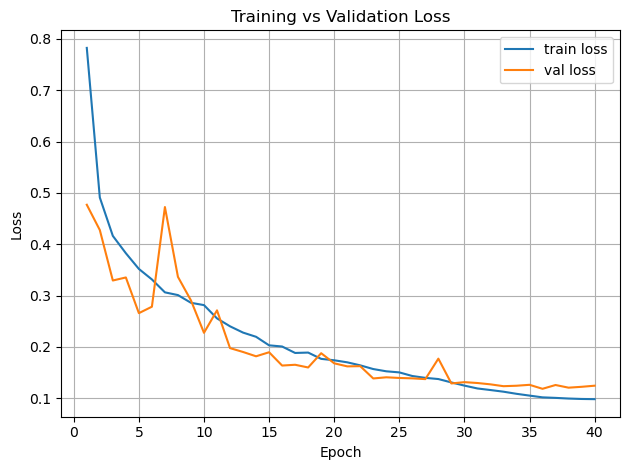

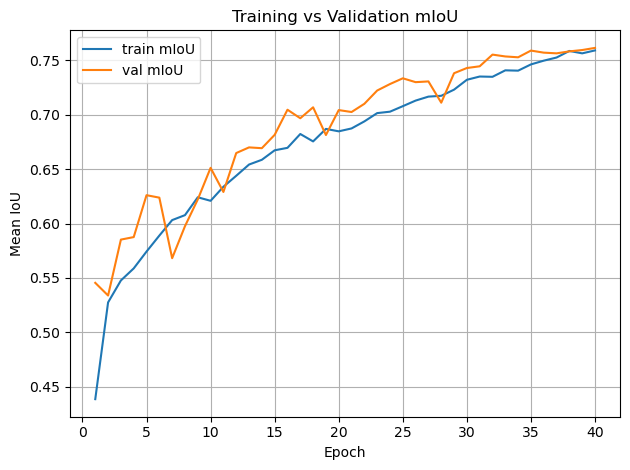

In [5]:
# Plot training curves
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history_teacher["train_loss"], label="train loss")
plt.plot(epochs, history_teacher["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history_teacher["train_miou"], label="train mIoU")
plt.plot(epochs, history_teacher["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)

load_checkpoint(
    path="checkpoints/best_teacher.pt",
    model=teacher,
    optimizer=None,
    scheduler=None,
    map_location=device,
)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=m

[checkpoint] Loaded model weights from checkpoints/best_teacher.pt


In [ ]:
from distillation import SegmentationKDLoss
epoch_student = 30
teacher_learning_rate = 1e-4
teacher_weight_decay = 1e-2
student_learning_rate = 5e-4
student_weight_decay = 5e-2
# Initializing student model and knowledge distillation setup
# load pretrained teacher (frozen)
teacher = create_teacher_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=64,
    bilinear=True,
).to(device)
load_checkpoint("checkpoints/best_teacher.pt", model=teacher, optimizer=None, scheduler=None, map_location=device)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

# fresh student
student = create_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=16,
    bilinear=True,
).to(device)

optimizer = create_optimizer(
    student,
    lr=student_learning_rate,         
    weight_decay=student_weight_decay,
    use_muon=use_muon,
)

scheduler = create_cosine_scheduler_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_epochs * len(train_loader)),
    num_training_steps=num_epochs * len(train_loader),
)

kd_loss_fn = SegmentationKDLoss(
    ignore_index=AI4MARS_IGNORE_INDEX,
    alpha=0.5,
    T=2.0,
)


[checkpoint] Loaded model weights from checkpoints/best_teacher.pt
[optimizers] Using NAdam (NadamW-style) optimizer.


In [8]:
from tqdm import tqdm
best_student_miou = -1.0
history = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}

for epoch_student in range(1, num_epochs + 1):
    print(f"\n[Distillation] Epoch {epoch}/{num_epochs}")
    student.train()

    if use_amp:
        scaler = torch.cuda.amp.GradScaler(enabled=True)
    else:
        scaler = None

    running_loss = 0.0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"KD Train {epoch}/{num_epochs}", unit="batch", leave=False)

    for imgs, masks in pbar:
        imgs = imgs.to(device, non_blocking=True).float()
        masks = masks.to(device, non_blocking=True).long()
        batch_size = imgs.size(0)
        total_samples += batch_size

        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            teacher_logits = teacher(imgs)

        if use_amp:
            with torch.cuda.amp.autocast():
                student_logits = student(imgs)
                loss = kd_loss_fn(student_logits, teacher_logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            student_logits = student(imgs)
            loss = kd_loss_fn(student_logits, teacher_logits, masks)
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * batch_size
        avg_loss = running_loss / max(total_samples, 1)
        pbar.set_postfix(loss=f"{avg_loss:.3f}")

    # eval student
    val_metrics = evaluate(
        model=student,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
        use_tqdm=True,
    )

    if val_metrics["miou"] > best_student_miou:
        best_student_miou = val_metrics["miou"]
        save_checkpoint(
            path="checkpoints/best_student_kd.pt",
            model=student,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            metrics={"val_miou": best_student_miou},
        )

    history["train_loss"].append(train_metrics["loss"])
    history["train_miou"].append(train_metrics["miou"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  KD Val - loss: N/A, mIoU: {val_metrics['miou']:.4f}, pix acc: {val_metrics['pixel_acc']:.4f}"
    )


/tmp/ipykernel_26841/4032536995.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)



[Distillation] Epoch 1/40


KD Train 1/40:   0%|          | 0/1302 [00:00<?, ?batch/s]/tmp/ipykernel_26841/4032536995.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.4229, mIoU: 0.5166, pix acc: 0.8738
  KD Val - loss: N/A, mIoU: 0.5166, pix acc: 0.8738

[Distillation] Epoch 2/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.4101, mIoU: 0.5480, pix acc: 0.8618
  KD Val - loss: N/A, mIoU: 0.5480, pix acc: 0.8618

[Distillation] Epoch 3/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 1.2168, mIoU: 0.3056, pix acc: 0.6120
  KD Val - loss: N/A, mIoU: 0.3056, pix acc: 0.6120

[Distillation] Epoch 4/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.3349, mIoU: 0.6099, pix acc: 0.9038
  KD Val - loss: N/A, mIoU: 0.6099, pix acc: 0.9038

[Distillation] Epoch 5/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2818, mIoU: 0.6303, pix acc: 0.9185
  KD Val - loss: N/A, mIoU: 0.6303, pix acc: 0.9185

[Distillation] Epoch 6/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2963, mIoU: 0.6193, pix acc: 0.9084
  KD Val - loss: N/A, mIoU: 0.6193, pix acc: 0.9084

[Distillation] Epoch 7/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2792, mIoU: 0.6182, pix acc: 0.9120
  KD Val - loss: N/A, mIoU: 0.6182, pix acc: 0.9120

[Distillation] Epoch 8/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2649, mIoU: 0.6265, pix acc: 0.9169
  KD Val - loss: N/A, mIoU: 0.6265, pix acc: 0.9169

[Distillation] Epoch 9/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2822, mIoU: 0.6182, pix acc: 0.9125
  KD Val - loss: N/A, mIoU: 0.6182, pix acc: 0.9125

[Distillation] Epoch 10/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2600, mIoU: 0.6425, pix acc: 0.9208
  KD Val - loss: N/A, mIoU: 0.6425, pix acc: 0.9208

[Distillation] Epoch 11/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2561, mIoU: 0.6328, pix acc: 0.9228
  KD Val - loss: N/A, mIoU: 0.6328, pix acc: 0.9228

[Distillation] Epoch 12/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2403, mIoU: 0.6517, pix acc: 0.9295
  KD Val - loss: N/A, mIoU: 0.6517, pix acc: 0.9295

[Distillation] Epoch 13/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2457, mIoU: 0.6412, pix acc: 0.9251
  KD Val - loss: N/A, mIoU: 0.6412, pix acc: 0.9251

[Distillation] Epoch 14/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2395, mIoU: 0.6499, pix acc: 0.9265
  KD Val - loss: N/A, mIoU: 0.6499, pix acc: 0.9265

[Distillation] Epoch 15/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2655, mIoU: 0.6382, pix acc: 0.9168
  KD Val - loss: N/A, mIoU: 0.6382, pix acc: 0.9168

[Distillation] Epoch 16/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2733, mIoU: 0.6231, pix acc: 0.9149
  KD Val - loss: N/A, mIoU: 0.6231, pix acc: 0.9149

[Distillation] Epoch 17/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2553, mIoU: 0.6392, pix acc: 0.9239
  KD Val - loss: N/A, mIoU: 0.6392, pix acc: 0.9239

[Distillation] Epoch 18/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2299, mIoU: 0.6583, pix acc: 0.9317
  KD Val - loss: N/A, mIoU: 0.6583, pix acc: 0.9317

[Distillation] Epoch 19/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2149, mIoU: 0.6688, pix acc: 0.9377
  KD Val - loss: N/A, mIoU: 0.6688, pix acc: 0.9377

[Distillation] Epoch 20/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2150, mIoU: 0.6654, pix acc: 0.9365
  KD Val - loss: N/A, mIoU: 0.6654, pix acc: 0.9365

[Distillation] Epoch 21/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2390, mIoU: 0.6516, pix acc: 0.9274
  KD Val - loss: N/A, mIoU: 0.6516, pix acc: 0.9274

[Distillation] Epoch 22/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2279, mIoU: 0.6587, pix acc: 0.9309
  KD Val - loss: N/A, mIoU: 0.6587, pix acc: 0.9309

[Distillation] Epoch 23/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2427, mIoU: 0.6465, pix acc: 0.9278
  KD Val - loss: N/A, mIoU: 0.6465, pix acc: 0.9278

[Distillation] Epoch 24/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2231, mIoU: 0.6574, pix acc: 0.9330
  KD Val - loss: N/A, mIoU: 0.6574, pix acc: 0.9330

[Distillation] Epoch 25/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2867, mIoU: 0.6273, pix acc: 0.9003
  KD Val - loss: N/A, mIoU: 0.6273, pix acc: 0.9003

[Distillation] Epoch 26/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2085, mIoU: 0.6691, pix acc: 0.9374
  KD Val - loss: N/A, mIoU: 0.6691, pix acc: 0.9374

[Distillation] Epoch 27/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2132, mIoU: 0.6728, pix acc: 0.9385
  KD Val - loss: N/A, mIoU: 0.6728, pix acc: 0.9385

[Distillation] Epoch 28/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2173, mIoU: 0.6623, pix acc: 0.9350
  KD Val - loss: N/A, mIoU: 0.6623, pix acc: 0.9350

[Distillation] Epoch 29/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2001, mIoU: 0.6745, pix acc: 0.9422
  KD Val - loss: N/A, mIoU: 0.6745, pix acc: 0.9422

[Distillation] Epoch 30/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.2026, mIoU: 0.6740, pix acc: 0.9413
  KD Val - loss: N/A, mIoU: 0.6740, pix acc: 0.9413

[Distillation] Epoch 31/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1990, mIoU: 0.6821, pix acc: 0.9430
  KD Val - loss: N/A, mIoU: 0.6821, pix acc: 0.9430

[Distillation] Epoch 32/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1924, mIoU: 0.6799, pix acc: 0.9435
  KD Val - loss: N/A, mIoU: 0.6799, pix acc: 0.9435

[Distillation] Epoch 33/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1879, mIoU: 0.6831, pix acc: 0.9464
  KD Val - loss: N/A, mIoU: 0.6831, pix acc: 0.9464

[Distillation] Epoch 34/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1909, mIoU: 0.6814, pix acc: 0.9450
  KD Val - loss: N/A, mIoU: 0.6814, pix acc: 0.9450

[Distillation] Epoch 35/40


[checkpoint] Saved checkpoint to checkpoints/best_student_kd.pt
  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1871, mIoU: 0.6858, pix acc: 0.9462
  KD Val - loss: N/A, mIoU: 0.6858, pix acc: 0.9462

[Distillation] Epoch 36/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1874, mIoU: 0.6819, pix acc: 0.9452
  KD Val - loss: N/A, mIoU: 0.6819, pix acc: 0.9452

[Distillation] Epoch 37/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1828, mIoU: 0.6855, pix acc: 0.9467
  KD Val - loss: N/A, mIoU: 0.6855, pix acc: 0.9467

[Distillation] Epoch 38/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1911, mIoU: 0.6833, pix acc: 0.9455
  KD Val - loss: N/A, mIoU: 0.6833, pix acc: 0.9455

[Distillation] Epoch 39/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1892, mIoU: 0.6810, pix acc: 0.9458
  KD Val - loss: N/A, mIoU: 0.6810, pix acc: 0.9458

[Distillation] Epoch 40/40


  Train - loss: 0.0983, mIoU: 0.7592, pix acc: 0.9725
  Val   - loss: 0.1853, mIoU: 0.6846, pix acc: 0.9465
  KD Val - loss: N/A, mIoU: 0.6846, pix acc: 0.9465


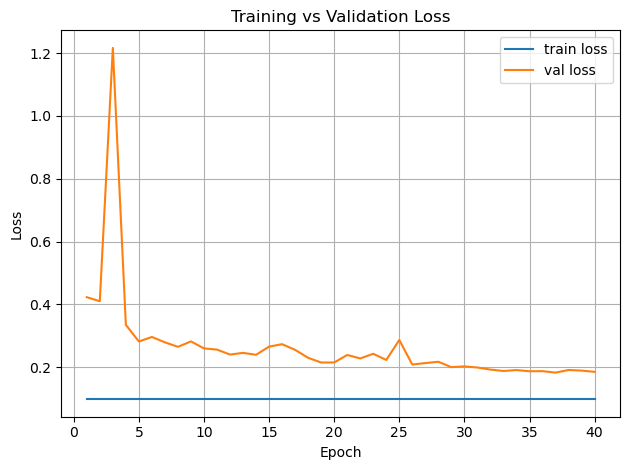

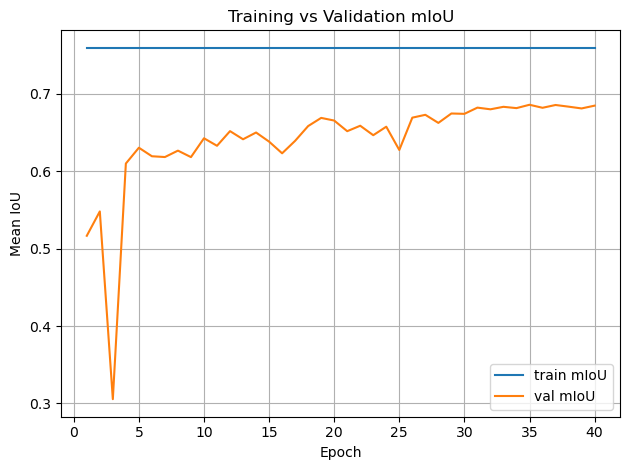

In [10]:
# Plot training curves
import pandas as pd
history = pd.read_csv("outputs/student_kd_training_history.csv")

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history["train_miou"], label="train mIoU")
plt.plot(epochs, history["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:


info = load_checkpoint(
    path="checkpoints/best_student_kd.pt",
    model=student,
    optimizer=optimizer,
    scheduler=scheduler,
    map_location=device,
)

print("Restored from epoch:", info["epoch"])
print("Stored metrics:", info["metrics"])


[checkpoint] Loaded model weights from checkpoints/best_student_kd.pt
[checkpoint] Restored optimizer state.
[checkpoint] Restored scheduler state.
Restored from epoch: 35
Stored metrics: {'val_miou': 0.685755849025393}


/home/georg/Documents/ESA/Maritan-Terrain-Sematic-Segmentation/train_utils.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=m

In [12]:
# Evaluate on test set
test_metrics = evaluate(
    model=student,
    dataloader=test_loader,
    device=device,
    num_classes=num_classes,
)

print("\nTest metrics:")
print(
    f"  loss: {test_metrics['loss']:.4f}, "
    f"mIoU: {test_metrics['miou']:.4f}, "
    f"pix acc: {test_metrics['pixel_acc']:.4f}"
)



Test metrics:
  loss: 0.2051, mIoU: 0.6811, pix acc: 0.9398


/tmp/ipykernel_26841/4130627921.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


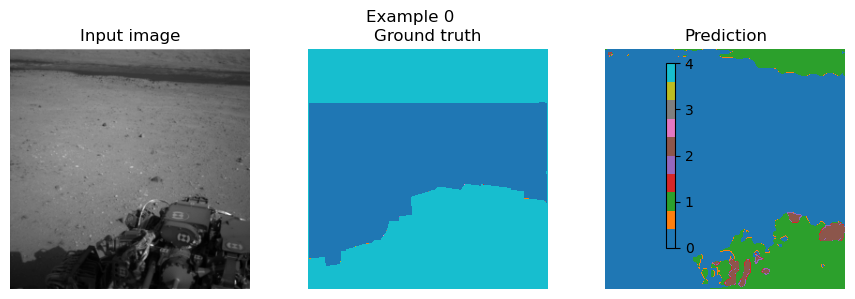

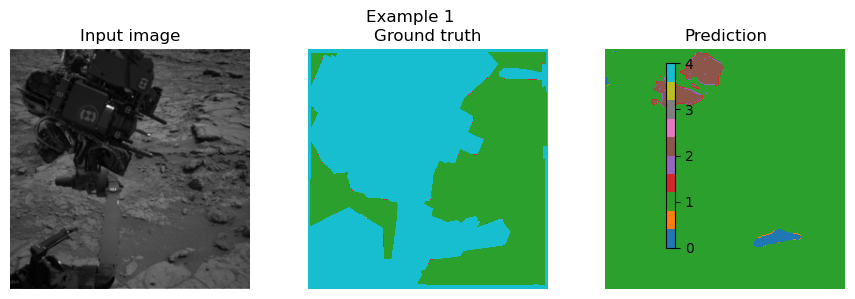

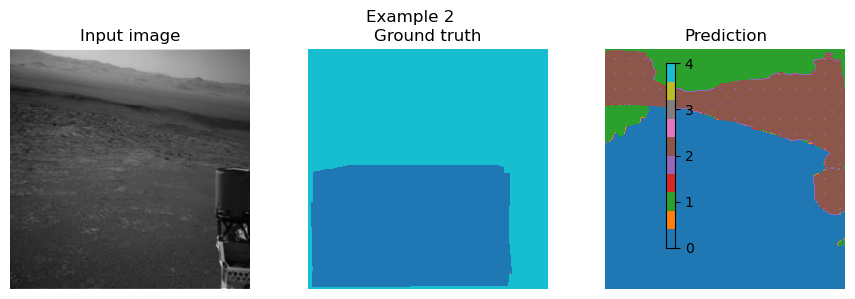

In [13]:
# Helper: visualize predictions vs ground truth
def decode_mask(mask_tensor):
    """Convert a [H,W] mask with indices into a numpy array for plotting."""
    mask_np = mask_tensor.cpu().numpy()
    return mask_np


def show_predictions(model, dataloader, num_examples: int = 3):
    model.eval()
    imgs, masks = next(iter(dataloader))

    imgs = imgs.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=1)

    for i in range(min(num_examples, imgs.size(0))):
        img = imgs[i, 0].cpu().numpy()  # [H,W]
        gt = decode_mask(masks[i])
        pred = decode_mask(preds[i])

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("Input image")
        axes[0].axis("off")

        im1 = axes[1].imshow(gt, vmin=0, vmax=num_classes, cmap="tab10")
        axes[1].set_title("Ground truth")
        axes[1].axis("off")

        im2 = axes[2].imshow(pred, vmin=0, vmax=num_classes, cmap="tab10")
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.8)
        plt.suptitle(f"Example {i}")
        plt.tight_layout()
        plt.show()


show_predictions(student, test_loader, num_examples=3)


Scanning dataset once to find examples per class...

=== Class 'soil' (id=0) | 3 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


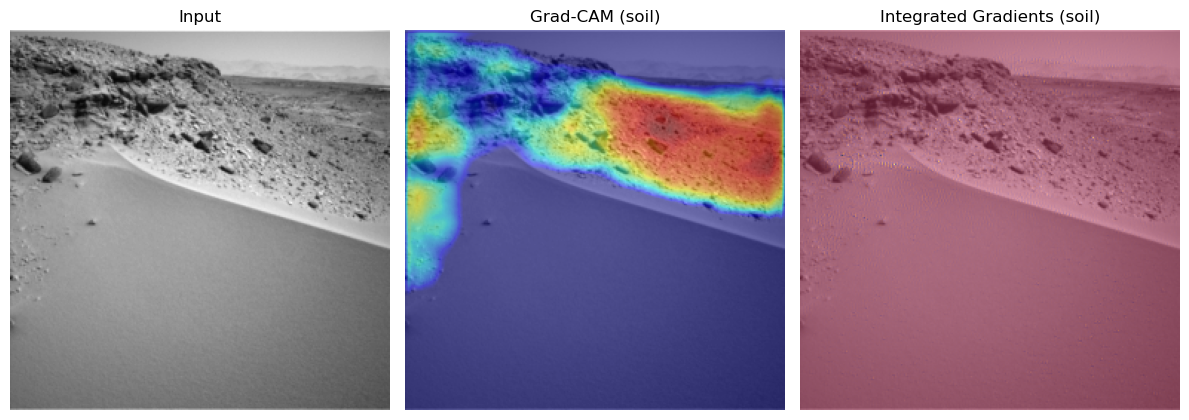


=== Class 'bedrock' (id=1) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 1)


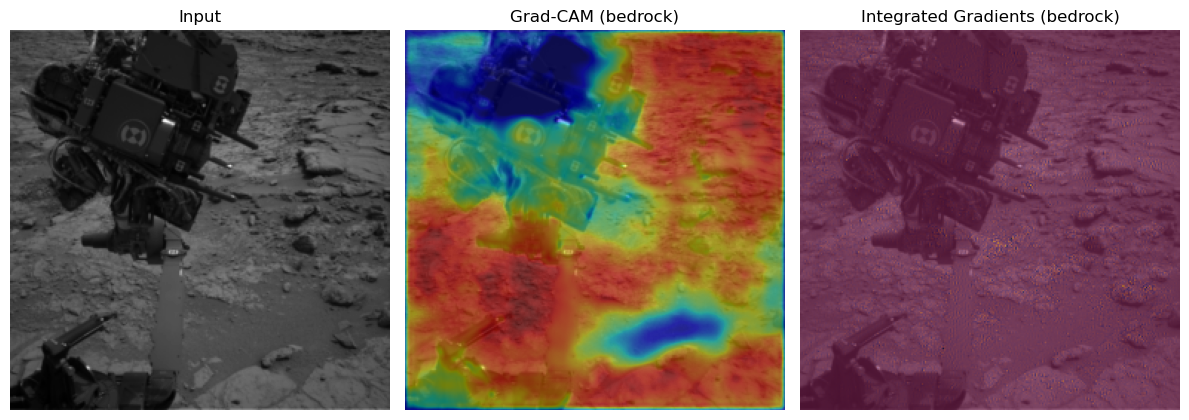


=== Class 'sand' (id=2) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


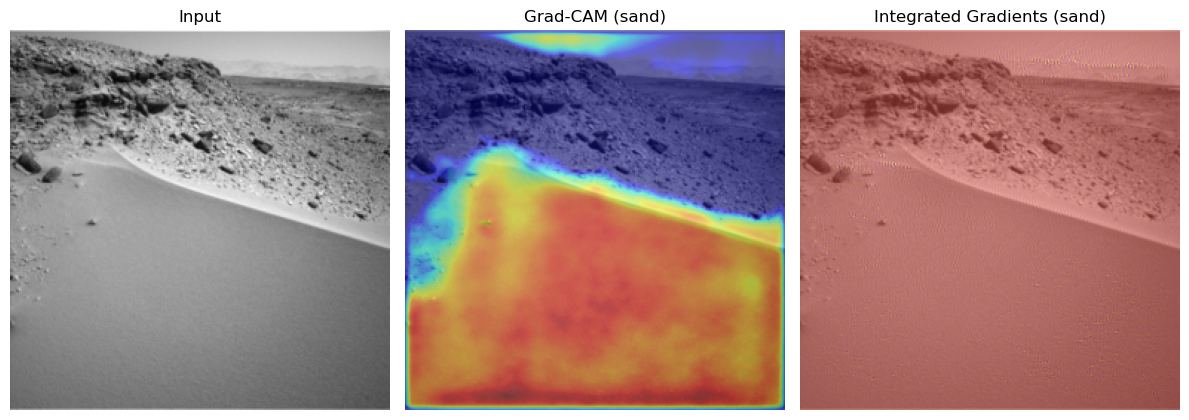


=== Class 'big_rock' (id=3) | 1 total examples, showing 1 ===
- Example 1/1 (dataset idx: 3)


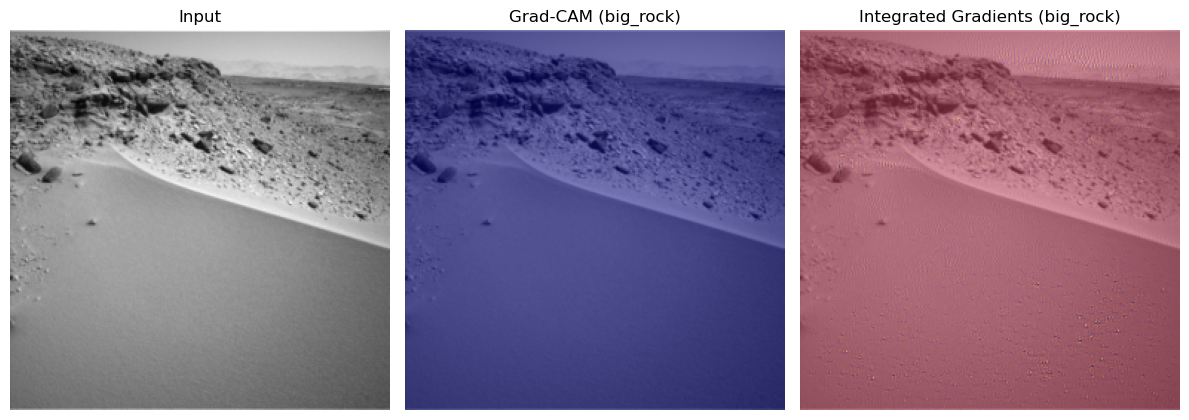

In [14]:
# Explainability demo:
# Grad-CAM, Integrated Gradients, Neural PCA for a single test image.
from explainability import explain_per_class_examples

num_examples_per_class = 1   
ig_steps = 32

explain_per_class_examples(
    model=student,
    dataset=test_loader.dataset,
    device=device,
    num_examples_per_class=num_examples_per_class,
    ig_steps=ig_steps,
)


[neural PCA] Scanning dataset for class presence...
[neural PCA] Class 0: using 200 samples for PCA out of 6402 candidates.
[neural PCA] Class 1: using 200 samples for PCA out of 8351 candidates.
[neural PCA] Class 2: using 200 samples for PCA out of 4330 candidates.
[neural PCA] Class 3: using 200 samples for PCA out of 1756 candidates.

Class 'soil' (id=0), NPCA component 1, showing top 5 / 200 images.


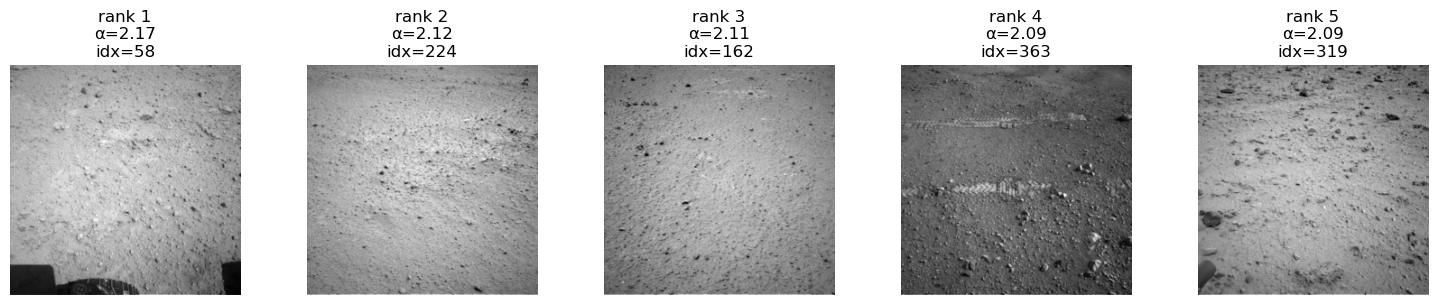


Class 'soil' (id=0), NPCA component 2, showing top 5 / 200 images.


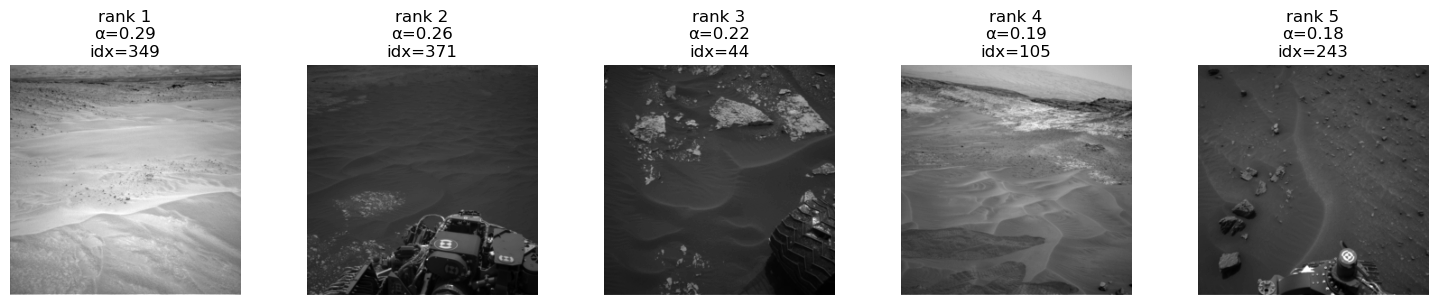


Class 'soil' (id=0), NPCA component 3, showing top 5 / 200 images.


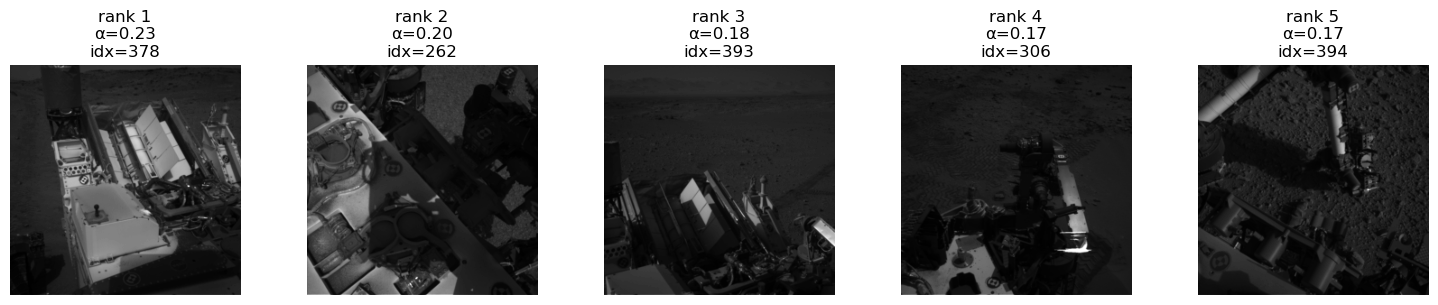


Class 'bedrock' (id=1), NPCA component 1, showing top 5 / 200 images.


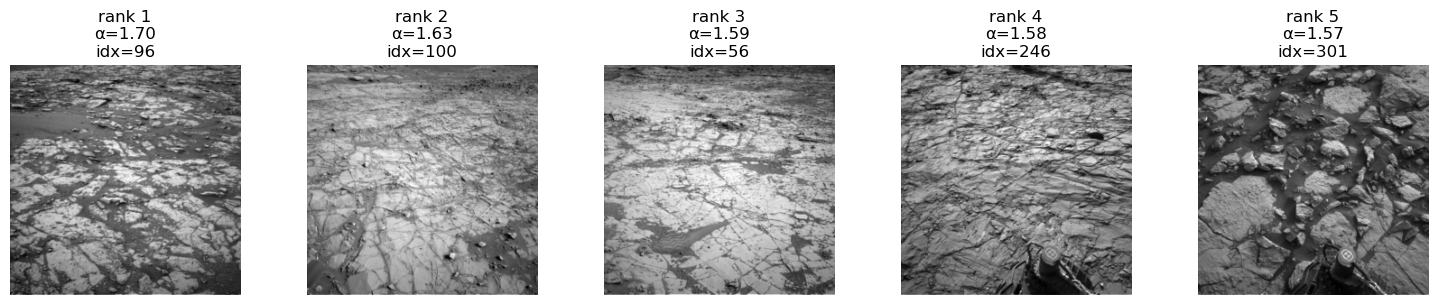


Class 'bedrock' (id=1), NPCA component 2, showing top 5 / 200 images.


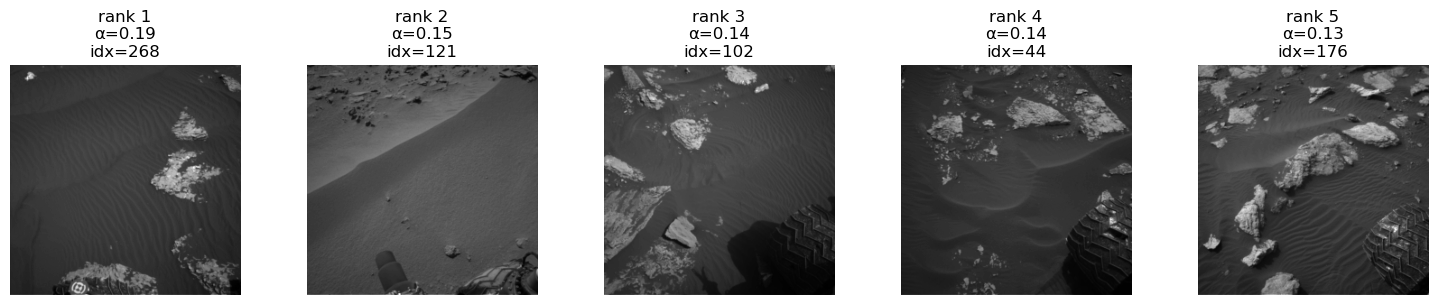


Class 'bedrock' (id=1), NPCA component 3, showing top 5 / 200 images.


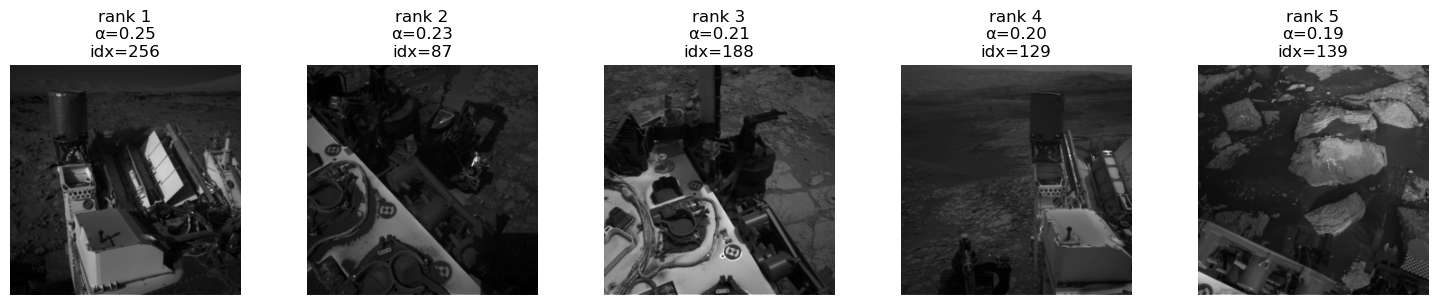


Class 'sand' (id=2), NPCA component 1, showing top 5 / 200 images.


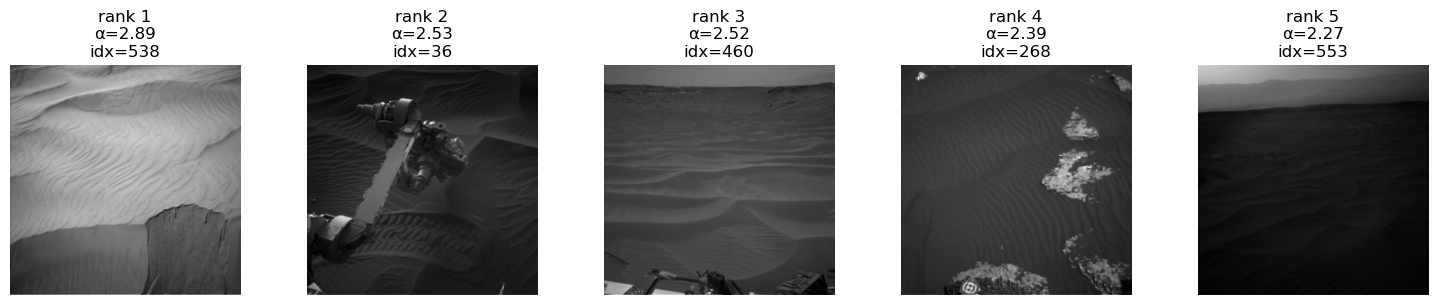


Class 'sand' (id=2), NPCA component 2, showing top 5 / 200 images.


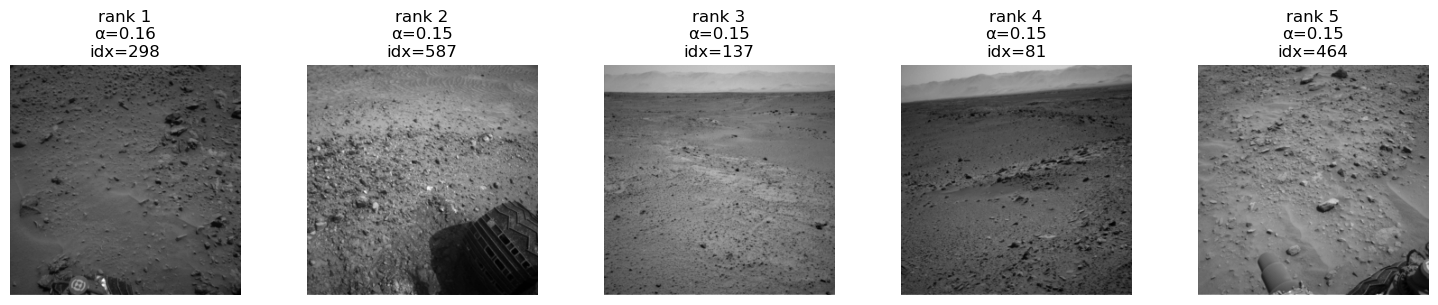


Class 'sand' (id=2), NPCA component 3, showing top 5 / 200 images.


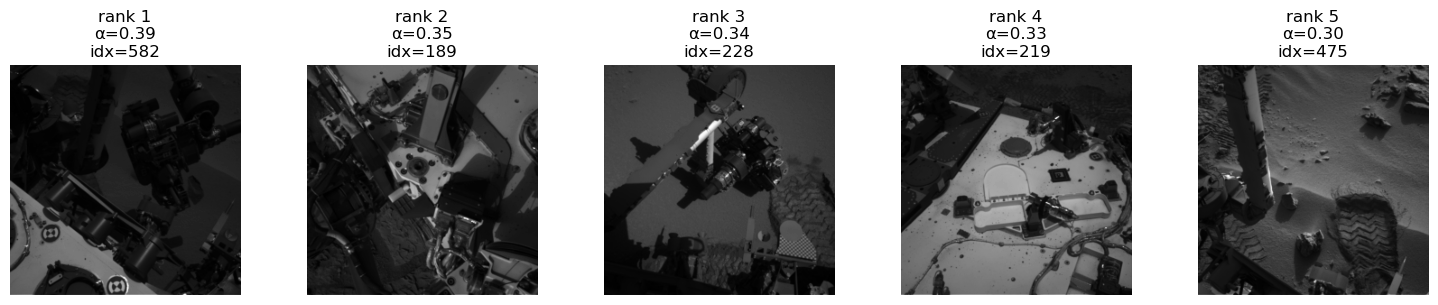


Class 'big_rock' (id=3), NPCA component 1, showing top 5 / 200 images.


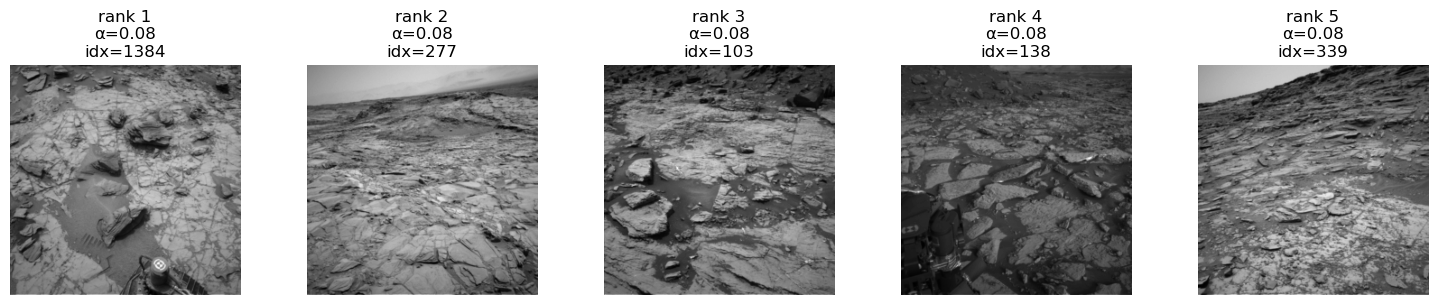


Class 'big_rock' (id=3), NPCA component 2, showing top 5 / 200 images.


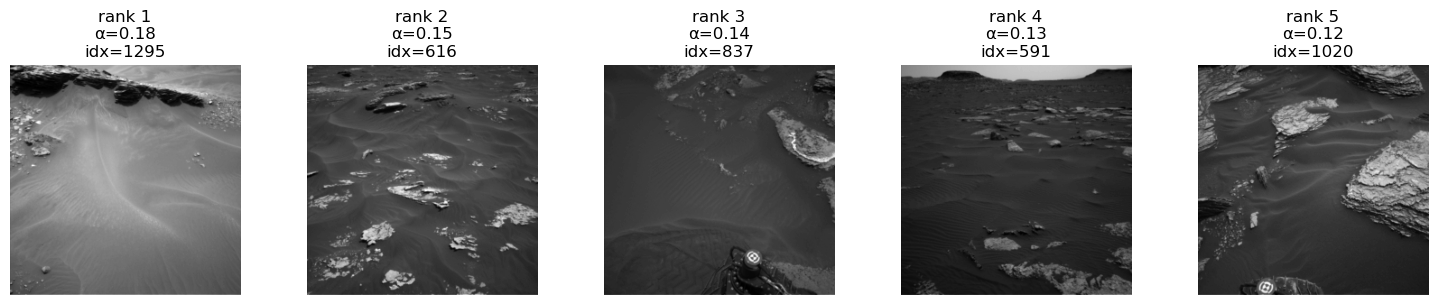


Class 'big_rock' (id=3), NPCA component 3, showing top 5 / 200 images.


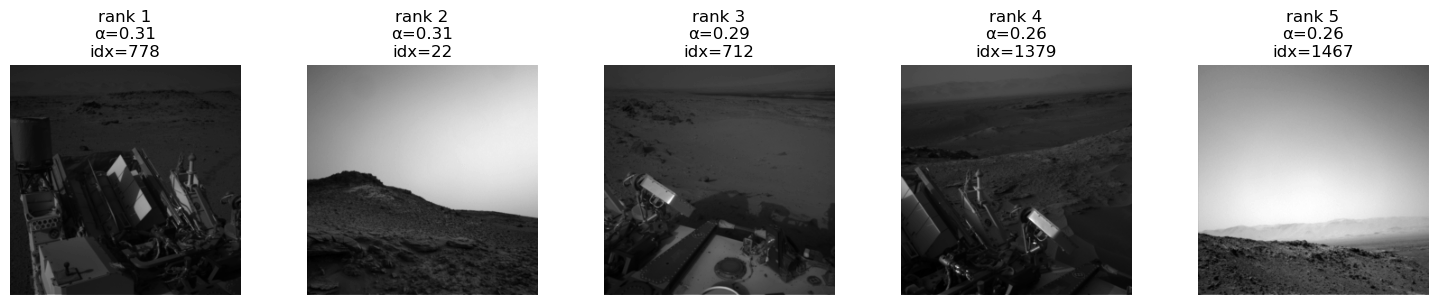

In [15]:
from explainability import compute_class_neural_pca_features, show_top_neural_pca_images_for_class

class_ids = list(range(len(AI4MARS_CLASS_NAMES)))  # [0,1,2,3]
max_samples_per_class = 200
n_pca_components = 3

neural_pca_results = compute_class_neural_pca_features(
    model=student,
    dataset=train_loader.dataset,   # usually use TRAIN set like in the paper
    device=device,
    class_ids=class_ids,
    max_samples_per_class=max_samples_per_class,
    n_components=n_pca_components,
    min_per_class=10,
)

for c in range(len(AI4MARS_CLASS_NAMES)):
    for comp in range(3):  # top 3 NPCA components
        show_top_neural_pca_images_for_class(
            neural_pca_results,
            dataset=train_loader.dataset,
            class_id=c,
            component_idx=comp,
            top_k=5,
        )


In [ ]:
from uncertainty import predictive_entropy, max_prob_uncertainty

student.eval()
imgs, masks = next(iter(test_loader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = student(imgs)                     
    preds = logits.argmax(dim=1)            

# choose one example
idx = 0
img_np = imgs[idx, 0].cpu().numpy()
gt_np = masks[idx].cpu().numpy()
pred_np = preds[idx].cpu().numpy()

# uncertainty maps
entropy_map = predictive_entropy(logits)[idx].cpu().numpy()
maxprob_unc = max_prob_uncertainty(logits)[idx].cpu().numpy()

# normalize for display (optional)
def norm01(x):
    x = x.astype("float32")
    x_min, x_max = x.min(), x.max()
    if x_max > x_min:
        return (x - x_min) / (x_max - x_min)
    return x * 0.0

entropy_disp = norm01(entropy_map)
maxprob_unc_disp = norm01(maxprob_unc)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img_np, cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(gt_np, cmap="tab20")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

axes[2].imshow(pred_np, cmap="tab20")
axes[2].set_title("Segmentation")
axes[2].axis("off")

axes[3].imshow(entropy_disp, cmap="turbo")  # or "inferno"
axes[3].set_title("Predictive Uncertainty")
axes[3].axis("off")

plt.tight_layout()
plt.show()


### TODO
    
    - hparam tuning
    - Clear the code and make nice docs
    - standardize the way of putting what in notebook and what in files
    - make website out of it
    - write it all like super nice blogpost
    - give the math of the explaining methods
    - add citations
    - discuss outcomes
    